# SXSW Tweets: Sentiment Analysis using NLP


**Authors**: Marcelo Scatena, Czarina Luna, Piotr Czolpik, Ross McKim

***
February 2022

<img src='images/header.jpeg' align='left'/>

[Image Source](https://www.hackreactor.com/blog/software-engineers-guide-to-sxsw-2021)

# Table of Contents
* [Overview](#Overview)
* [Business Problem](#Business_Problem)
* [Data Understanding](#Data_Understanding)
* [I. Data Exploration](#Data_Exploration)
    * [Text Preprocessing](#Text_Preprocessing)
    * [Word Clouds](#Wordclouds)
    * [Word Vectorization](#Vectorization)
* [II. Data Modeling](#Data_Modeling)    
    * [Classification Models](#Classification)
    * [Neural Network](#Neural_Network)
    * [Clustering](#Clustering)
    * [LDA](#LDA)
* [III. Final Model](#Final_Model)
* [IV. Results](#Results)
* [V. Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

# Overview <a class="anchor" id="Overview"></a>
We are digital brand advisors that have been hired by South by Southwest. Our goal in this analysis is to do a proof of concept measure of the effect of the Apple pop up tent on twitter sentiment at the 2011 SXSW festival. In 2011, Apple released the iPad 2 at the SXSW festival which makes this an ideal situation for analyzing first impressions of a small group of people.

- Attendees of technology festivals usually have a strong social presence
- First impressions of products can influence a great deal in sale numbers
- Sentiment analysis can help companies understand what they're doing right, and what they need to improve

# Business Problem <a class="anchor" id="Business_problem"></a>
South by Southwest is primarily a film and music event and may not have expertise in analyzing social media postings but this measure of sentiment could help determine how much the event charges for booths, advertisements, and other commercial exposures. We are examining how effectively we can measure sentiment during such an event. To accomplish this task we used a Machine Learning model that uses Natural Language Processing and distinguishes between positive, negative, or neutral sentiment in a tweet. The focus though is on being able to classify the highest amount of Negative sentiments, since they are the ones that may influence others that are still undecided on purchasing a product.



# Data Understanding <a class="anchor" id="Data_Understanding"></a>
The information we have is regarding the 2011 South by Southwest festival that introduced the iPad 2. It is from data.world, which can be found [here](https://data.world/crowdflower/brands-and-product-emotions). It contains over 9,000 tweets from users talking about the festival and it's products, and the sentiment of the tweet has been categorized by it being either positive, negative, neutral or unable to tell. There is a big imbalance of results in that regard, and another one when taking into consideration which products those sentiments are regarding.

# I. Data Exploration <a class="anchor" id="Data_Exploration"></a>
To start with, we load the dataset and explore its values.

In [1]:
# Load data using Python library, Pandas
import pandas as pd

raw_data = pd.read_csv('./data/tweets.csv', encoding='latin1')
raw_data.head(2)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion


In [2]:
# Look at columns and null values per column
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There are a total of 9,093 rows and 3 columns, all of object or string data types.

In [3]:
# Change column names for convenience
raw_data.columns = ['text', 'product', 'target']

In [4]:
# How many null values are there per column
raw_data.isnull().sum()

text          1
product    5802
target        0
dtype: int64

There is only one missing value under text. The product column has almost 6,000 missing values, but it is not as important, since it is not a feature variable.

In [5]:
# How many duplicate values in the data
raw_data.duplicated().sum()

22

In [6]:
# Remove the single missing value and small number of duplicates in text column
# that is the feature variable
raw_data = raw_data.dropna(subset=['text']).drop_duplicates(subset=['text'])

In [7]:
# What are the different values for the product column and their percentages
raw_data['product'].value_counts(normalize=True)

iPad                               0.287500
Apple                              0.200915
iPad or iPhone App                 0.142988
Google                             0.130488
iPhone                             0.090244
Other Google product or service    0.089329
Android App                        0.024390
Android                            0.023476
Other Apple product or service     0.010671
Name: product, dtype: float64

In [8]:
# What are the different values for the target column and their percentages
raw_data['target'].value_counts(normalize=True)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: target, dtype: float64

Majority of the target values is neutral sentiment. A little over 30% accounts for positive sentiment, and only 6% accounts for negative sentiment.

In [9]:
# Import Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

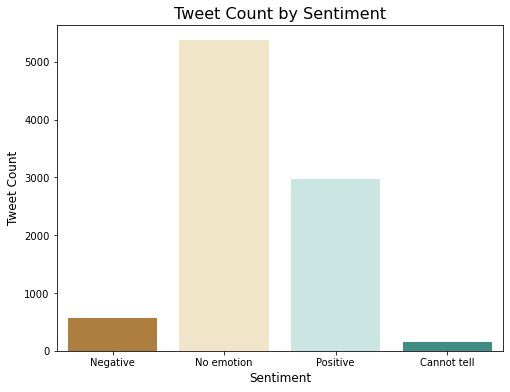

In [10]:
# Visualize the count of classes of target variable
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='target', data=raw_data, palette='BrBG', order=['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"])
ax.set_title('Tweet Count by Sentiment', fontsize=16)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_xticklabels(['Negative', 'No emotion', 'Positive', 'Cannot tell'])
ax.set_ylabel('Tweet Count', fontsize=12)
plt.show()

In [11]:
# Drop the 'cannot tell' class due to very small number of count
raw_data = raw_data.drop((raw_data.loc[raw_data['target']=="I can't tell"]).index)

In [12]:
# Create a column to categorize products into either Apple, Google, or Unknown brand
apple_products = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google_products = ['Google', 'Other Google product or service', 'Android App', 'Android']

raw_data['brand'] = raw_data['product'].apply(lambda x: 'google' if x in google_products else ('apple' if x in apple_products else 'unknown'))

In [13]:
# What is the count of each class per brand
pd.DataFrame(raw_data.groupby(['brand', 'target'])['text'].count())

text
brand   target                                  
apple   Negative emotion                     387
        No emotion toward brand or product    65
        Positive emotion                    1943
google  Negative emotion                     131
        No emotion toward brand or product    26
        Positive emotion                     719
unknown Negative emotion                      51
        No emotion toward brand or product  5281
        Positive emotion                     306

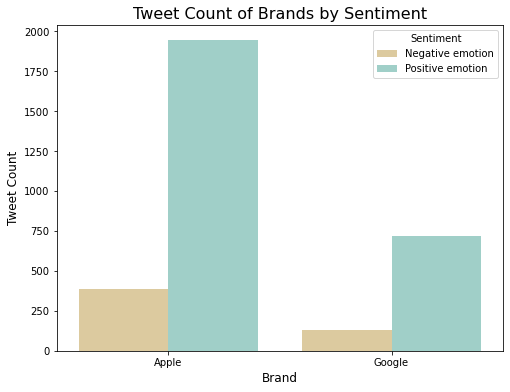

In [14]:
# Visualize the count of positive vs negative sentiment for each brand
brand_only = raw_data.loc[(raw_data['brand']!='unknown') & (raw_data['target']!='No emotion toward brand or product')]

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='brand', data=brand_only, hue='target', palette='BrBG')
ax.set_title('Tweet Count of Brands by Sentiment', fontsize=16)
ax.set_xlabel('Brand', fontsize=12)
ax.set_xticklabels(['Apple', 'Google'])
ax.set_ylabel('Tweet Count', fontsize=12)
ax.legend(['Negative', 'Positive'])
plt.legend(title='Sentiment')
plt.show()

Between negative and positive sentiments, there are a lot more positive sentiments for both brands. Overall, Apple has higher count of tweets, for both sentiments.

In [15]:
# Change the values of target variable to 0-2
target_values = {'No emotion toward brand or product':1, 'Positive emotion':2, 'Negative emotion':0}

raw_data['target'] = raw_data['target'].map(target_values)

Let's perform some feature engineering, and add tweet length as another variable.

In [16]:
# Create new columns measuring the length of tweets
raw_data['words'] = raw_data['text'].apply(lambda x: len(x.split()))
raw_data['char'] = raw_data['text'].apply(lambda x: len(x))

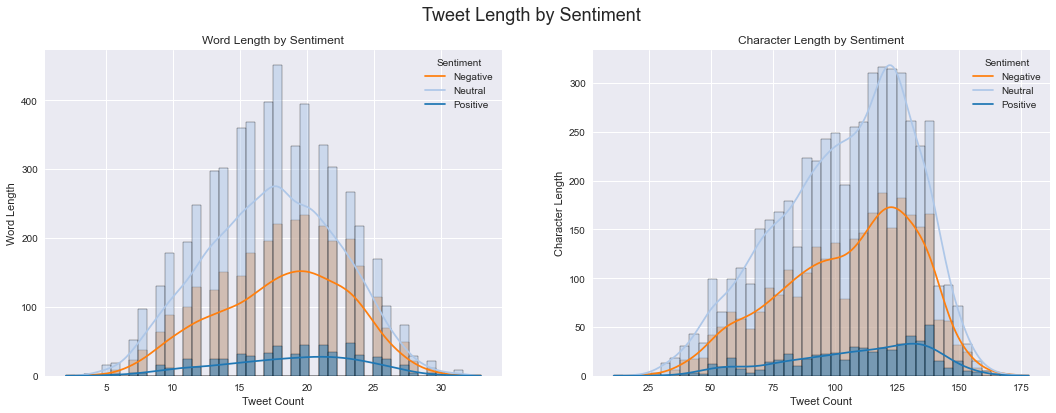

In [17]:
# Visualize the difference, if any, between length of tweets among the three target sentiments

plt.style.use('seaborn')

fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
fig.suptitle('Tweet Length by Sentiment', fontsize=18)

sns.histplot(x='words', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[0], palette='tab20')
axes[0].set_title('Word Length by Sentiment')
axes[0].set_xlabel('Tweet Count')
axes[0].set_ylabel('Word Length')
axes[0].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

sns.histplot(x='char', data=raw_data, bins='auto', kde=True, hue='target', legend=True, ax=axes[1], palette='tab20')
axes[1].set_title('Character Length by Sentiment')
axes[1].set_xlabel('Tweet Count')
axes[1].set_ylabel('Character Length')
axes[1].legend(['Negative', 'Neutral', 'Positive'], title='Sentiment')

plt.show()

Graph on the left shows length of tweet by number of words. The values are normally distributed across all sentiments. Graph on the right shows length of tweet by number of characters. Similarly, the values are normally distributed. There appears to be no significant difference among target sentiments with regards to length of tweets.

## Train Test Split
After the initial exploration above, it is now time to split the data into training and testing sets. We will only look at the training set from now on, and hold out the testing set for final evaluation at the end of data modeling.

In [18]:
# Use Python library scikit-learn to split the data
from sklearn.model_selection import train_test_split
X = raw_data['text']
y = raw_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

In [ ]:
# Store the y_train series, to use in other notebook
%store y_train

In [ ]:
# Store the y_test series, to use in other notebook
%store y_test

In [23]:
# Transform the tweets using the CountVectorizer, and store frequencies in a dataframe
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')

raw_words = cv.fit_transform(X_train)
raw_sum = raw_words.sum(axis=0)

raw_freq = [(word.title(), raw_sum[0, i]) for word, i in cv.vocabulary_.items()]
raw_freq = sorted(raw_freq, key=lambda x: x[1], reverse=True)
words_freq = pd.DataFrame(raw_freq, columns=['word', 'frequency'])

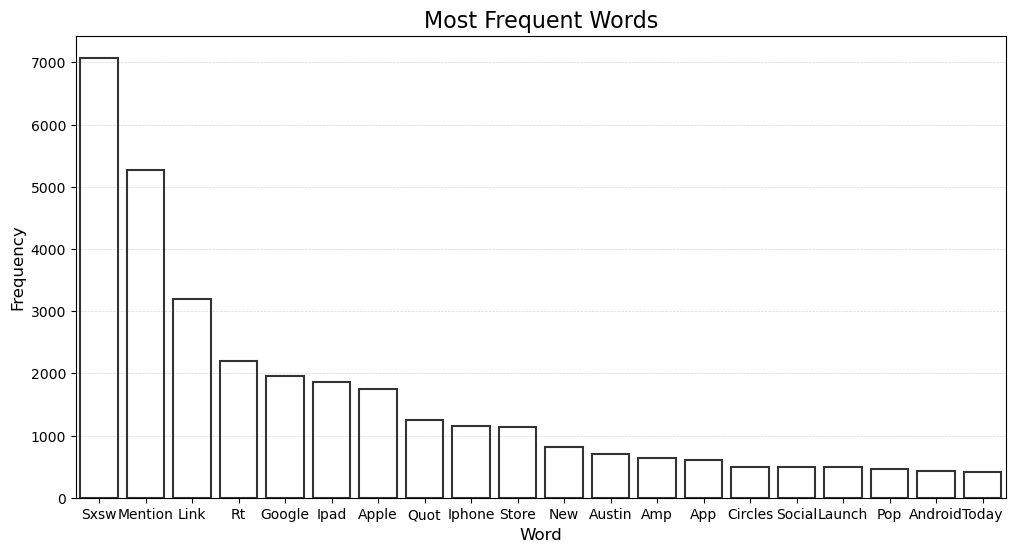

In [24]:
# Visualize the most frequent words in the dataset
plt.style.use('default')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=words_freq.head(20), linewidth=1.5, facecolor=(1, 1, 1, 0), errcolor=".2", edgecolor=".2", zorder=3)
ax.set_title('Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

Meaning of the most frequent words:
1. **Sxsw** - on top of the list, the name of the conference during which these tweets are posted
2. **Mention** - referring to usernames mentioned in the tweets
3. **Link** - referring to hyperlinks attached to the tweets
4. **Rt** - short for retweet, when the tweet is shared as a so-called retweet from the original tweet

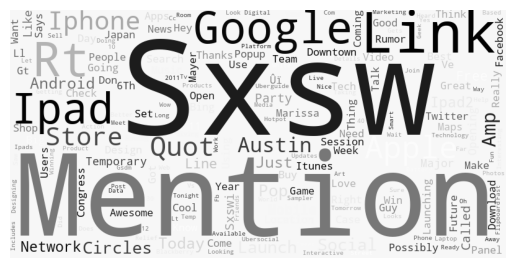

In [25]:
# Visualize the most frequent words using WordCloud
from wordcloud import WordCloud

raw_wordcloud = WordCloud(background_color='#f7f7f7', width=800, height=400, colormap='Greys_r', random_state=1).generate_from_frequencies(dict(raw_freq))

plt.figure()
plt.imshow(raw_wordcloud)
#plt.title('SXSW Tweets Word Cloud')
plt.axis('off')
plt.show()

The biggest words in the word cloud above overlap with the most frequently occurring words shown in the bar graph earlier. Most of these are common words with general meanings, such as twitter-specific labels, and of course, the brands and products themselves. They do not tell us about the sentiment of the tweet, but only refer to the subject of the tweet, and therefore not useful to analysis. 

To proceed with understanding the sentiments, it is essential to perform text preprocessing.

## Text Preprocessing<a class="anchor" id="Text_Preprocessing"></a>

In [26]:
# Let's take a sample of 5 tweets from the train set
train_sample = pd.DataFrame(X_train.sample(5, random_state=112221))
train_sample['label'] = [y_train[val] for val in train_sample.index]
train_sample

,text,label
5758,RT @mention Funny that even CNN is saying to s...,1
7358,Vinh: Flipboard is a step forward for iPad mag...,2
6306,RT @mention Mayer: 20% of Google searches are ...,1
4092,&quot;Apple is the most elegant fascist compan...,0
2369,It's official! I'm buying an iPad. #SXSW #elevate,2


In [27]:
# Let's look at the first tweet in the sample
sample_0 = train_sample.loc[5758, 'text']
sample_0

'RT @mention Funny that even CNN is saying to stay clear of Austin Apple store on Friday (iPad 2 launch) cuz of #sxsw. {link}'

This tweet exactly contains some of the most frequent words identified earlier: RT, mention, Austin, Apple, store, iPad, sxsw, and link. This also contains special characters: the @ sign to mention a username, and the # sign to refer to the hashtag.

The other tweets in the sample show similar characteristics.

### Step 1. Standardization
The first step of our text preprocessing is to standardize the text.

In [28]:
# Turn all letters to lowercase text
sample_0 = sample_0.lower()
sample_0

'rt @mention funny that even cnn is saying to stay clear of austin apple store on friday (ipad 2 launch) cuz of #sxsw. {link}'

### Step 2. Remove Patterns
The second step of our text preprocessing is to remove patterns such as the special characters.

In [29]:
# Use Python package re to remove punctuations
import re
sample_0 = re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', sample_0)
sample_0

'rt mention funny that even cnn is saying to stay clear of austin apple store on friday ipad 2 launch cuz of sxsw link'

In [30]:
# Remove other patterns such as numbers, and words with less than 3 letters
sample_0 = sample_0.replace('[^a-zA-Z#]', ' ').replace('quot', '')
sample_0 = ' '.join([i for i in sample_0.split() if len(i)>3])
sample_0

'mention funny that even saying stay clear austin apple store friday ipad launch sxsw link'

### Step 3. Tweet Tokenization
The third step of our text preprocessing is to tokenize the text into single words.

In [31]:
# Split the text into single words
sample_0 = sample_0.split()
sample_0

['mention',
 'funny',
 'that',
 'even',
 'saying',
 'stay',
 'clear',
 'austin',
 'apple',
 'store',
 'friday',
 'ipad',
 'launch',
 'sxsw',
 'link']

### Step 4. Remove Stopwords
The fourth step of our text preprocessing is to remove stopwords, which are common English words that frequently occur in text, and across all positive, negative, and neutral sentiments.

In [32]:
# Use the natural language toolkit or nltk to create a list of stopwords
import nltk
stopwords = nltk.corpus.stopwords.words('english')
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [33]:
# Let's create our list of stopwords specific to the sxsw tweets
sxsw_stopwords = ['sxsw', 
                  'sxswi', 
                  'link', 
                  'quot', 
                  'rt',
                  'amp',
                  'mention',
                  'apple', 
                  'google', 
                  'iphone', 
                  'ipad', 
                  'ipad2',
                  'austin', 
                  'today', 
                  'quotroutearoundquot', 
                  'rtmention', 
                  'store', 
                  'doesnt', 
                  'theyll']

In [34]:
# Extend the list of stopwords to include the list above
stopwords.extend(sxsw_stopwords)

In [35]:
# Remove the stopwords from the tweet
sample_0 = [word for word in sample_0 if word not in stopwords]
sample_0

['funny', 'even', 'saying', 'stay', 'clear', 'friday', 'launch']

### Step 5. Lemmatization
The fifth step of our text preprocessing is to lemmatize the words in the text. This will group inflected or variant forms of the same word. For example, a plural word becomes singular.

In [36]:
# Lemmatize words using WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

sample_0 = [lemmatizer.lemmatize(word) for word in sample_0]
sample_0

['funny', 'even', 'saying', 'stay', 'clear', 'friday', 'launch']

After the five steps of text processing, change the list back to a single string.

In [37]:
# Put all the words back together
sample_0 = ' '.join(sample_0)
sample_0

'funny even saying stay clear friday launch'

Let's put together all of the processing steps taken above.

In [38]:
# Create function to lowercase text, remove patterns, tokenize, remove stopwords, and lemmatize
def preprocess(text):
    text = text.apply(lambda x: x.lower())
    text = text.apply(lambda x: re.sub(r'([^A-Za-z0-9|\s|[:punct:]]*)', '', x))
    text = text.apply(lambda x: x.replace('[^a-zA-Z#]', ' ').replace('quot', '').replace(':', '').replace('sxsw', ''))
    text = text.apply(lambda x: ' '.join([i for i in x.split() if len(i)>3]))
    text = text.apply(lambda x: x.split())
    text = text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    text = text.apply(lambda x: [word for word in x if word not in stopwords])
    text = text.apply(lambda x: ' '.join(x))
    return text

In [39]:
# Apply the function to our sample from the train test
train_sample['text'] = preprocess(train_sample['text'])
train_sample

,text,label
5758,funny even saying stay clear friday launch,1
7358,vinh flipboard step forward mag right path wir...,2
6306,mayer search local information,1
4092,elegant fascist company america flipboard,0
2369,official buying elevate,2


### Transforming Data
Apply the text preprocessing function to the full dataset.

In [40]:
# Create new series for processed train and test sets.
X_train_processed = preprocess(X_train)
X_test_processed = preprocess(X_test)

In [ ]:
# Store the X_train_processed series, to use in other notebook
%store X_train_processed

In [ ]:
# Store the X_test_processed series, to use in other notebook
%store X_test_processed

In [43]:
# Transform the preprocessed text using CountVectorizer, and store frequencies in a dataframe
processed_words = cv.fit_transform(X_train_processed)
processed_sum = processed_words.sum(axis=0)

processed_freq = [(word.title(), processed_sum[0, i]) for word, i in cv.vocabulary_.items()]
processed_freq = sorted(processed_freq, key=lambda x: x[1], reverse=True)
processed_words_freq = pd.DataFrame(processed_freq, columns=['word', 'frequency'])

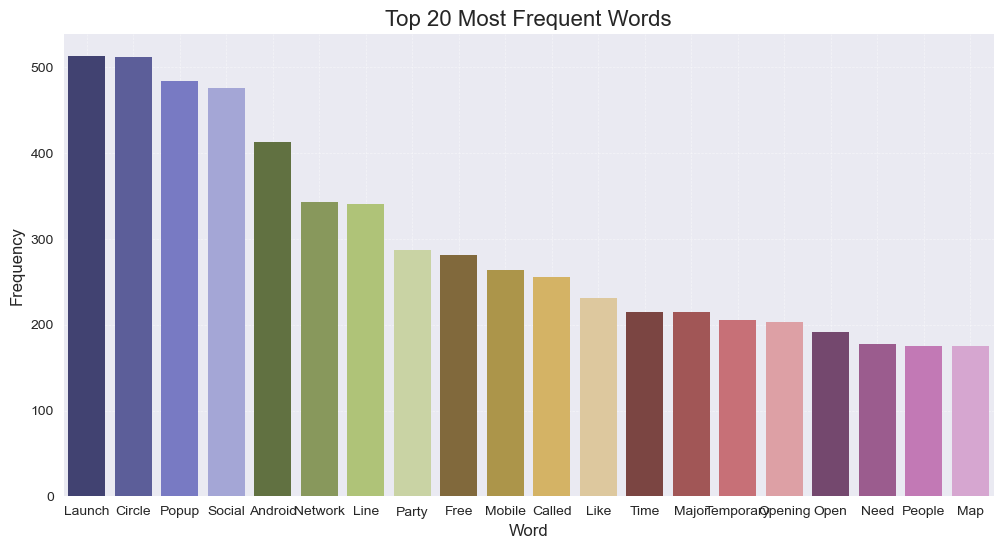

In [44]:
# Visualize the most frequent words in the preprocessed train set
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.barplot(x='word', y='frequency', data=processed_words_freq.head(20), palette='tab20b', zorder=3)
ax.set_title('Top 20 Most Frequent Words', fontsize=16)
ax.set_xlabel('Word', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)

## Word Clouds<a class="anchor" id="Wordclous"></a>
Let's create word clouds for the transformed train dataset.

In [45]:
# Join the feature and target variables of the train set
train_set_processed = pd.concat([X_train_processed, y_train], axis=1)

In [46]:
# Create a dictionary of all words per sentiment
from nltk.tokenize import RegexpTokenizer
regex_token = RegexpTokenizer(r'\w+')

sentiment_dict = {}
for idx, name in enumerate(['negative_target', 'neutral_target', 'positive_target']):
    sentiment_text = train_set_processed['text'].loc[train_set_processed['target']==idx].tolist()
    sentiment_data = ' '.join(sentiment_text)
    sentiment_dict[name] = set(regex_token.tokenize(sentiment_data))

In [47]:
# Create a variable for each sentiment with all the words in a single string
str_negative = ' '.join(sentiment_dict['negative_target'])
str_neutral = ' '.join(sentiment_dict['neutral_target'])
str_positive = ' '.join(sentiment_dict['positive_target'])

# Another set of variables with only unique words in each sentiment, may not use below
# unique_negative = ' '.join(A-(B|C))
# unique_neutral = ' '.join(B-(A|C))
# unique_positive = ' '.join(C-(A|B))

In [48]:
# Create a function to create wordclouds and using images to mask
from PIL import Image
import numpy as np

def create_wordcloud(str_sentiment, filename, color, bg_color='black', contour_color=None, contour_width=0, random_state=1):
    mask = np.array(Image.open(f'images/{filename}'))
    
    wc = WordCloud(max_font_size=175, width=1000, height=1000, mask=mask, max_words=125, colormap=color, 
                   background_color=bg_color, contour_color=contour_color, contour_width=contour_width,
                   random_state=random_state).generate(str_sentiment)

    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

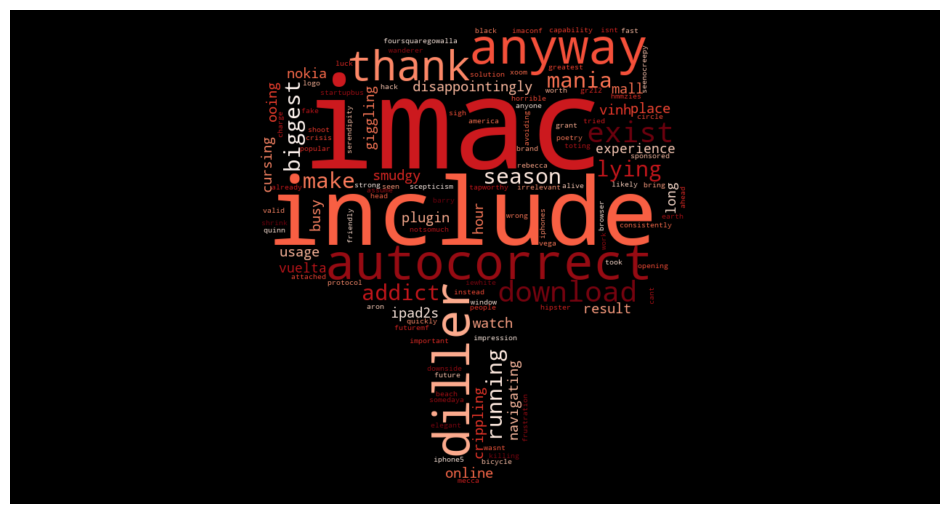

In [49]:
# Create wordcloud of all negative sentiments
create_wordcloud(str_negative, 'negative.jpeg', 'Reds_r', 'black')

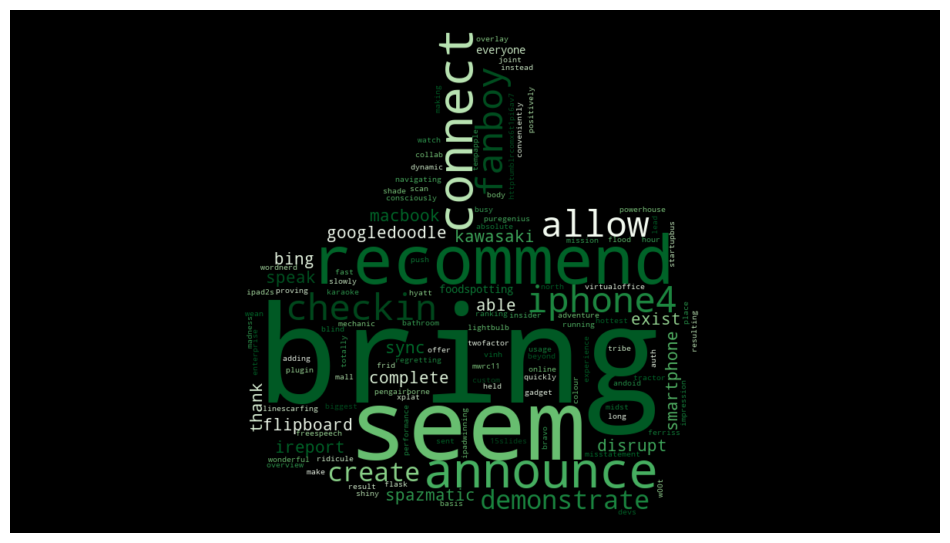

In [50]:
# Create wordcloud of all positive sentiments
create_wordcloud(str_positive, 'positive.jpeg', 'Greens_r', 'black')

In [51]:
# Create a dictionary of all words per brand, 
# and a variable for each brand with all the words in a single string

brand_dict = {}
for brand in ['apple', 'google']:
    brand_text = train_set_processed['text'].loc[raw_data.loc[X_train_processed.index,'brand']==brand].tolist()
    brand_data = ' '.join(brand_text)
    brand_dict[brand] = set(regex_token.tokenize(brand_data))
    
str_apple = ' '.join(brand_dict['apple'])
str_google = ' '.join(brand_dict['google'])

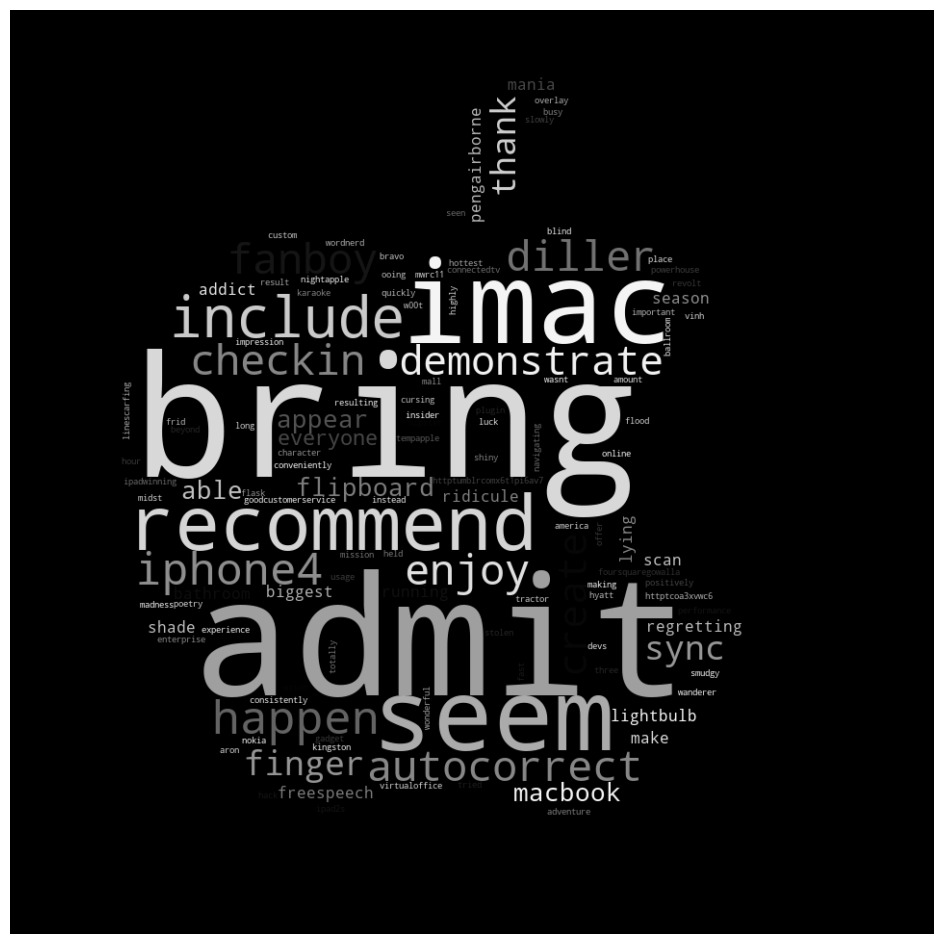

In [52]:
# Create wordcloud of all apple tweets
create_wordcloud(str_apple, 'apple.jpeg', 'Greys', 'black')

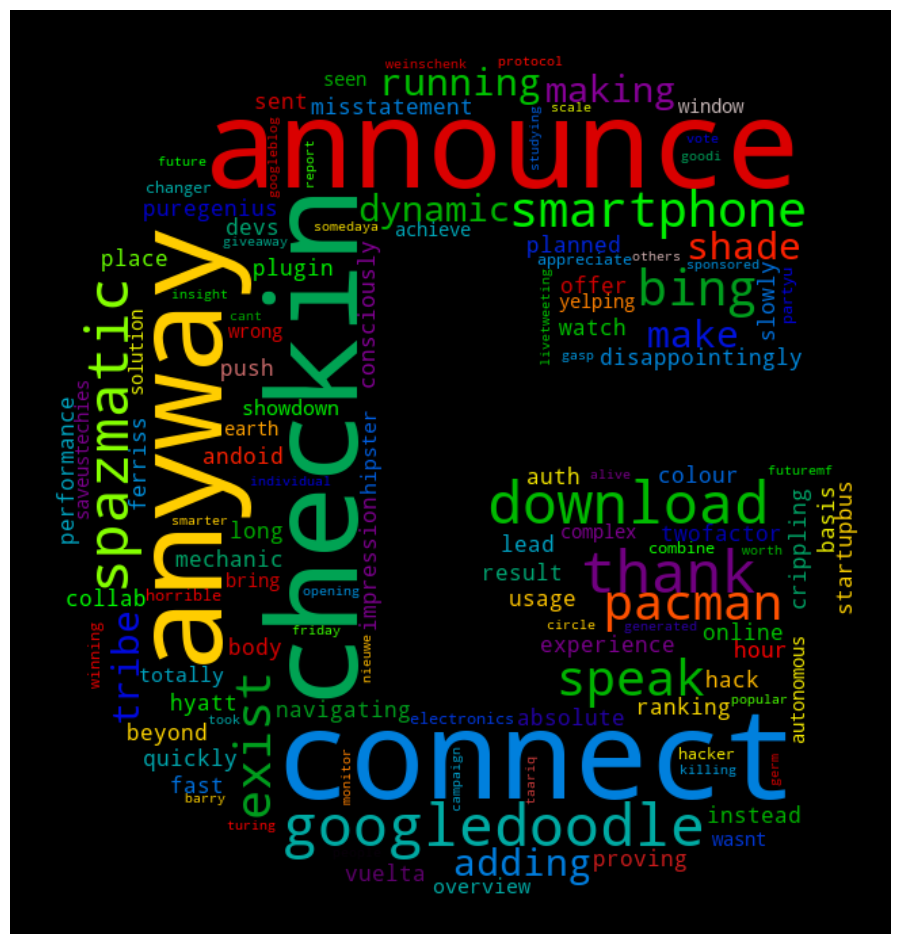

In [53]:
# Create wordcloud of all google tweets
create_wordcloud(str_google, 'google.jpeg', 'nipy_spectral_r', random_state=2)

### Group by Brand and Sentiment

Let's create a few bag of words grouped according to brand and sentiment.

In [54]:
# Create a function to remove additional stopwords
adtl_stopwords = ['sxsw', 'link', 'apple', 'people', 'one', 'year', 'ipad', 'google', 'store', 'quot', 'iphone', 'austin', 'app', 'ipad2', 'android', 'pop', 'amp', 'new', 'line', 'day', 'time', 'today', 'launch', 'major', 'title', 'via', 'network', 'called', 'u', 'v', 'say', 'see']

def remove_stopwords(text):
    '''
    Input: Text series
    Output: Text series without additional stopwords
    '''
    new_text = text.split()
    new_list = [word for word in new_text if word not in adtl_stopwords]
    new_str = ' '.join(new_list)
    return new_str

In [55]:
# Create function to group words according to brand and sentiment
def group_brand_sent(brand, target, sentiment):
    brand_data = train_set_processed.loc[raw_data.loc[X_train_processed.index,'brand']==brand]
    
    brand_sentiment_data = brand_data[brand_data['target']==target]
    
    brand_sentiment = ''
    for row in brand_sentiment_data['text']:
        brand_sentiment += row

    brand_sentiment_no_sw = remove_stopwords(brand_sentiment)
    brand_sentiment_wc = ''.join(brand_sentiment_no_sw)
    
    return brand_sentiment_wc

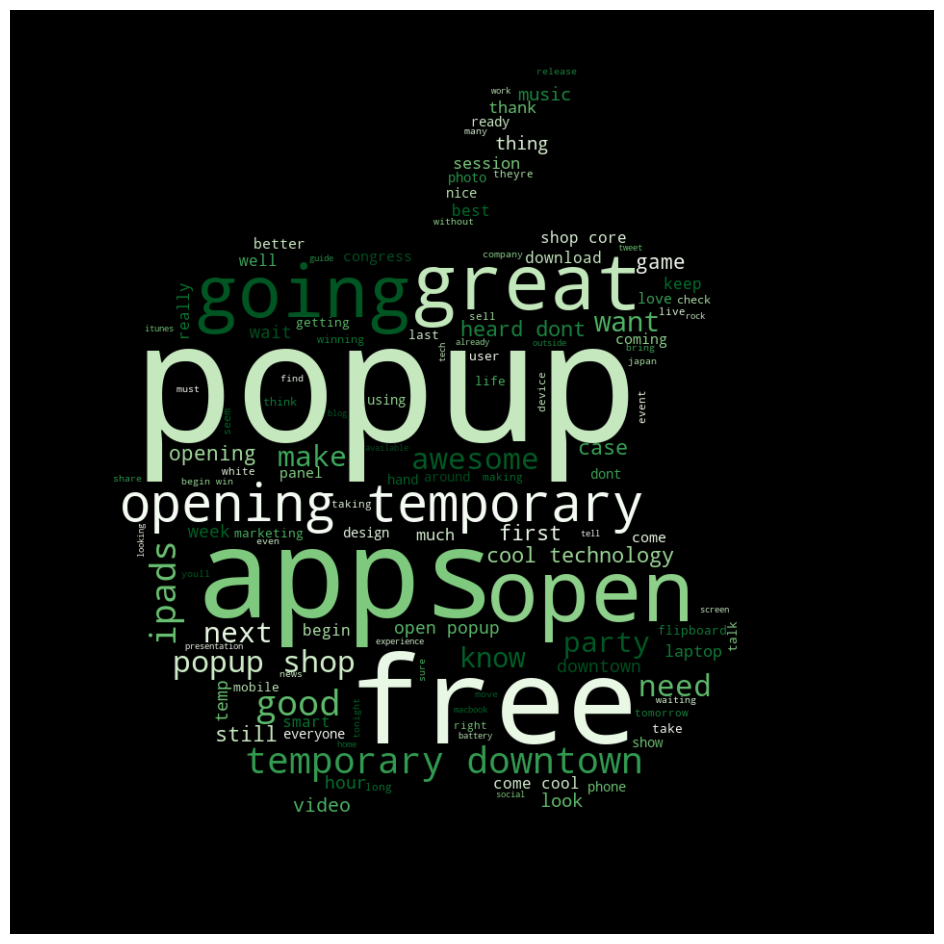

In [56]:
# Create wordcloud of all apple and positive sentiments
apple_positive_wc = group_brand_sent('apple', 2, 'positive')
create_wordcloud(apple_positive_wc, 'apple.jpeg', 'Greens', 'black')

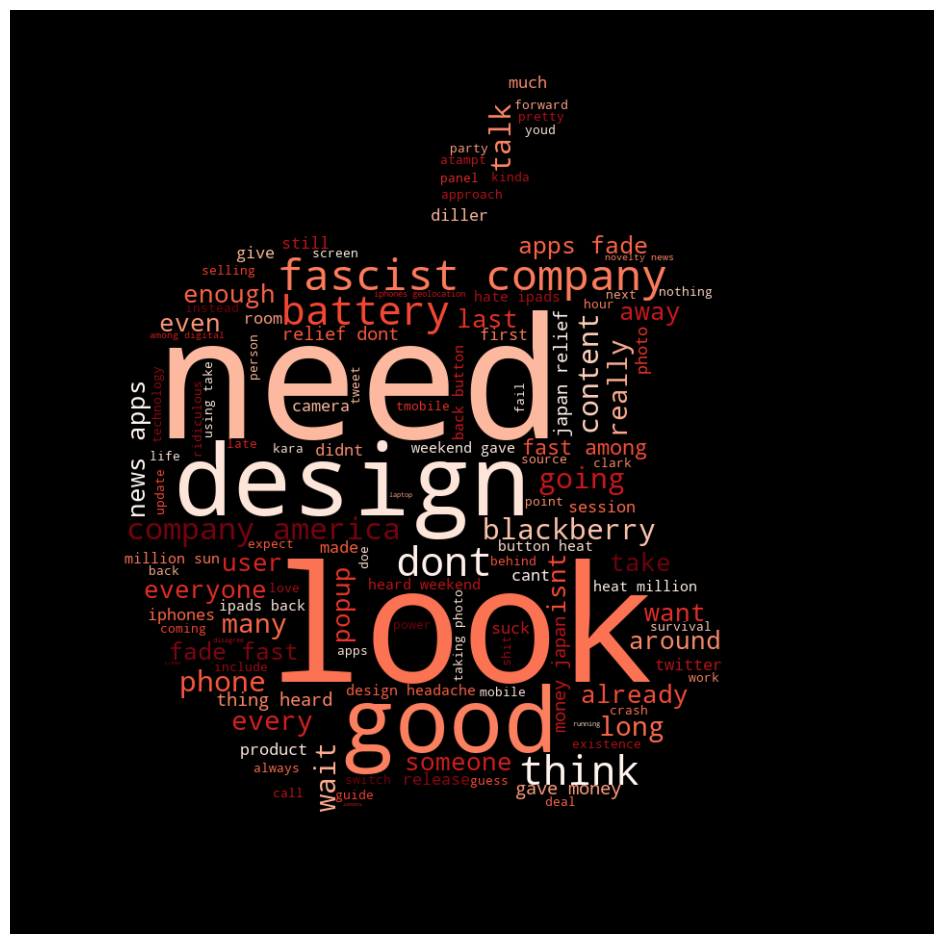

In [57]:
# Create wordcloud of all apple and negative sentiments
apple_negative_wc = group_brand_sent('apple', 0, 'negative')
create_wordcloud(apple_negative_wc, 'apple.jpeg', 'Reds', 'black')

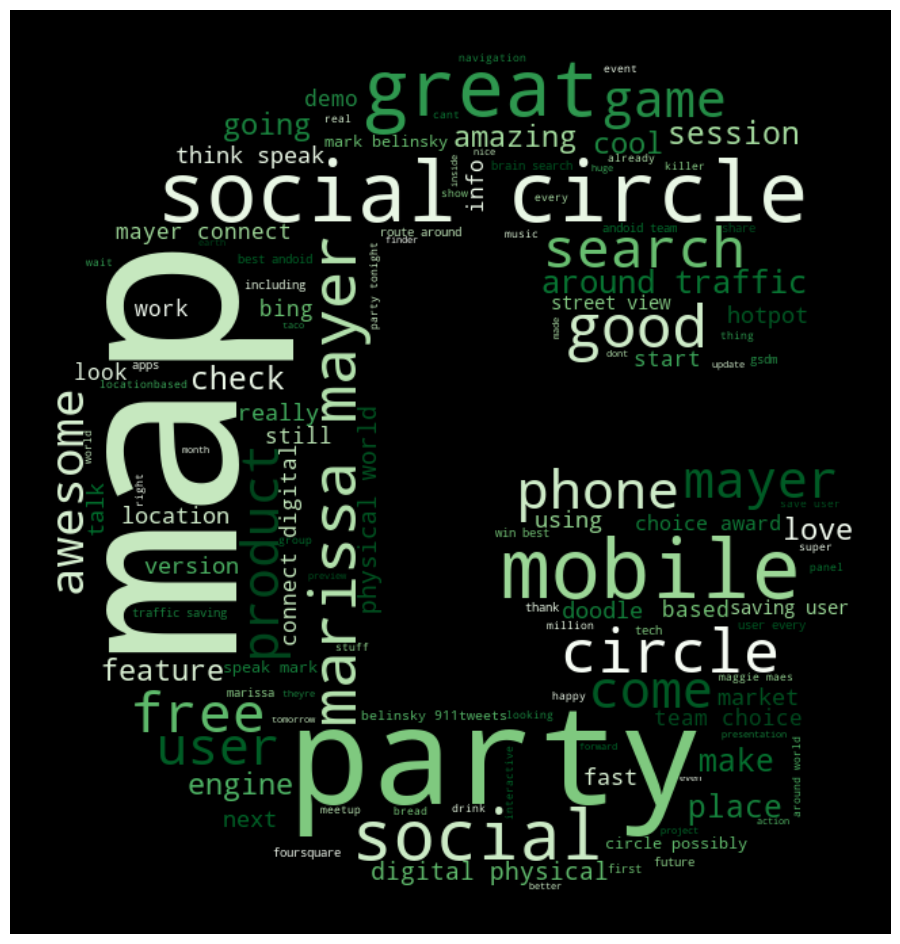

In [58]:
# Create wordcloud of all google and positive sentiments
google_positive_wc = group_brand_sent('google', 2, 'positive')
create_wordcloud(google_positive_wc, 'google.jpeg', 'Greens')

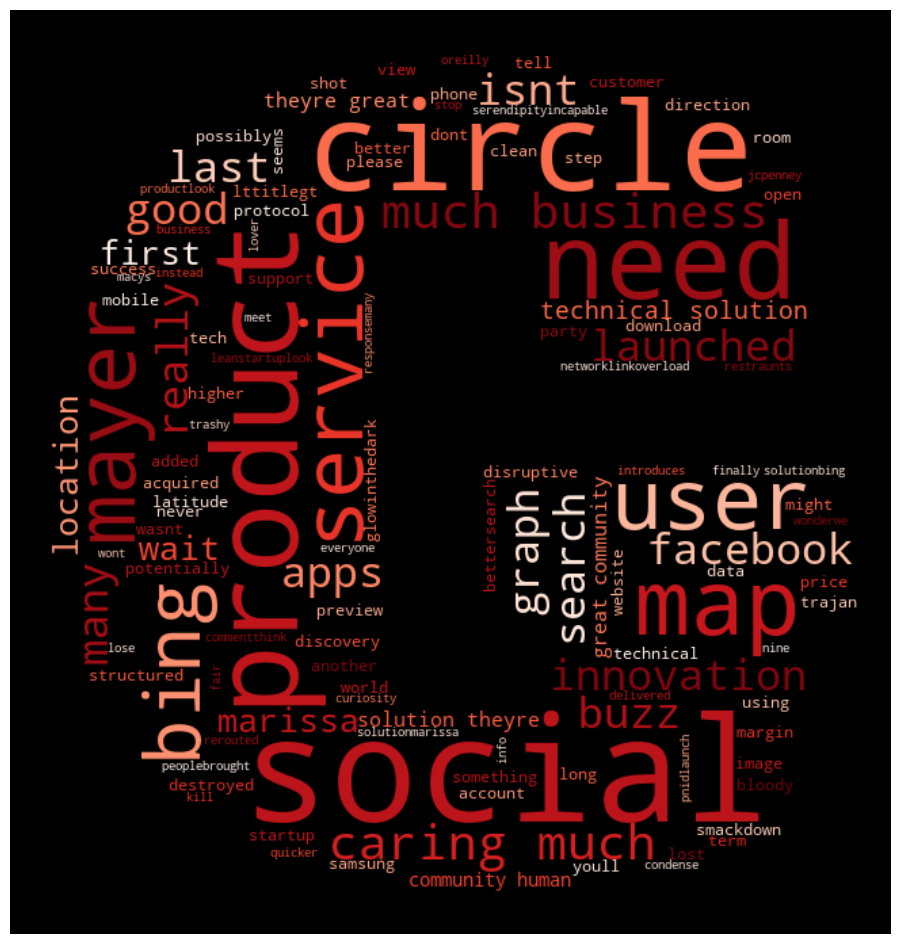

In [59]:
# Create wordcloud of all google and negative sentiments
google_negative_wc = group_brand_sent('google', 0, 'negative')
create_wordcloud(google_negative_wc, 'google.jpeg', 'Reds')

## Vectorization<a class="anchor" id="Vectorization"></a>

Next, let's explore word embeddings for our text using Word2Vec, a technique for natural language processing to map the words to vectors of real numbers.

In [60]:
# Import Word2Vec from Python library gensim and apply to processed train data
from gensim.models import Word2Vec
from nltk import word_tokenize

X_train_w2v = X_train_processed.map(word_tokenize)

w2v_model = Word2Vec(X_train_w2v, window=5, min_count=1, workers=4)
w2v_model.train(X_train_w2v, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

wv = w2v_model.wv

In [61]:
# Create a function to show most similar words, or are closest to the given word
def show_most_similar(word, length=10):
    return wv.most_similar(word, topn=length)

### Examine Word Vectors
Let's use the function created above to explore the following keywords.

In [62]:
show_most_similar('apple')

[('setting', 0.9961190819740295),
 ('sell', 0.9961069822311401),
 ('move', 0.9934449791908264),
 ('west', 0.9918560981750488),
 ('congress', 0.9916018843650818),
 ('smart', 0.9913069009780884),
 ('bldg', 0.9908022880554199),
 ('hooray', 0.9900141358375549),
 ('sixth', 0.9899235963821411),
 ('lease', 0.9895235896110535)]

In [63]:
show_most_similar('google')

[('activity', 0.9820076823234558),
 ('bread', 0.981834888458252),
 ('releasing', 0.9817649126052856),
 ('moma', 0.9817531108856201),
 ('schwag', 0.9817303419113159),
 ('old', 0.9817137122154236),
 ('freak', 0.981713056564331),
 ('push', 0.9816458225250244),
 ('4square', 0.9816234111785889),
 ('east', 0.9815647602081299)]

In [64]:
show_most_similar('iphone')

[('detached', 0.9256682395935059),
 ('dance', 0.9206105470657349),
 ('extensive', 0.9202919006347656),
 ('wordnerd', 0.9197046756744385),
 ('bingo', 0.9178497791290283),
 ('1230pmpart', 0.9174989461898804),
 ('tweetaholic', 0.9174014329910278),
 ('billmurray', 0.917320966720581),
 ('utilize', 0.9170446395874023),
 ('wouldnt', 0.9168475866317749)]

In [65]:
show_most_similar('android')

[('choice', 0.9990475177764893),
 ('heading', 0.9987457394599915),
 ('phone', 0.9987263679504395),
 ('available', 0.9987029433250427),
 ('drink', 0.9980816841125488),
 ('band', 0.9980200529098511),
 ('blackberry', 0.9979550838470459),
 ('food', 0.9979363083839417),
 ('guide', 0.9977729320526123),
 ('hello', 0.9977625608444214)]

Furthermore, let's take a look at the most common pairs of consecutive words, also known as bi-grams. 

In [67]:
# Import TweetTokenizer, a tokenizer especially created for tweets
from nltk.collocations import *
from nltk import TweetTokenizer

tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

X_train_twt = tweet_tokenizer.tokenize(' '.join(X_train_w2v.apply(lambda x: ' '.join(x))))

In [68]:
# Use BigramAssocMeasures from nltk
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(X_train_twt)
bigrams = finder.score_ngrams(bigram_measures.raw_freq)

In [69]:
# Display the top 50 bigrams
bigrams[:50]

[(('social', 'network'), 0.007517455218720025),
 (('called', 'circle'), 0.005242142363202391),
 (('network', 'called'), 0.005219835374422807),
 (('major', 'social'), 0.004639853666153606),
 (('launch', 'major'), 0.004506011733476098),
 (('circle', 'possibly'), 0.0037252671261906356),
 (('marissa', 'mayer'), 0.003011443485243927),
 (('opening', 'temporary'), 0.002186084900399295),
 (('popup', 'shop'), 0.0020745499565013718),
 (('open', 'popup'), 0.0018514800687055254),
 (('temporary', 'downtown'), 0.0018291730799259408),
 (('downtown', 'launch'), 0.0015837962033505098),
 (('opening', 'popup'), 0.001316112337995494),
 (('launch', 'social'), 0.0012938053492159093),
 (('rumor', 'opening'), 0.00124919137165674),
 (('includes', 'uberguide'), 0.0010930424501996475),
 (('ubersocial', 'includes'), 0.0010930424501996475),
 (('network', 'circle'), 0.0008699725624038012),
 (('anyone', 'know'), 0.0007584376185058779),
 (('[', 'codes'), 0.0007361306297262932),
 (('codes', 'valid'), 0.000736130629726

# II. Data Modeling <a class="anchor" id="Data_Modeling"></a>
The first model we use is Logistic Regression. It is a common classification model to classify binary classes as well as multi-class categories, such as in this case. For a baseline, we run a logistic regression model on the raw dataset, in which the texts are not processed. To improve this model, we then use the preprocessed text, and also change the vectorizer. To evaluate the model's performance, we use accuracy score as our metric for finding how many correct predictions the model makes, across all the target classes. Then we will run more complex classification models, tune their hyperparameters, and finally make use of a neural network. Additionally, we use unsupervised machine learning algorithms called clustering and LDA in separate notebooks linked below.

## Baseline Model

In [70]:
# Perform the train test split on raw data
raw_X = raw_data['text']
raw_y = raw_data['target']
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(raw_X, raw_y, random_state=112221, stratify=raw_y)

In [71]:
# Run the logistic regression on the raw train data and evaluate the accuracy score on the raw test data
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

baseline_model = LogisticRegression(max_iter=1000, random_state=112221)

baseline_pipeline = Pipeline(steps=[('vectorizer', cv), ('baseline', baseline_model)])
baseline_pipeline.fit(raw_X_train, raw_y_train)

baseline_y_pred = baseline_pipeline.predict(raw_X_test)
accuracy_score(raw_y_test, baseline_y_pred)

0.6876122082585279

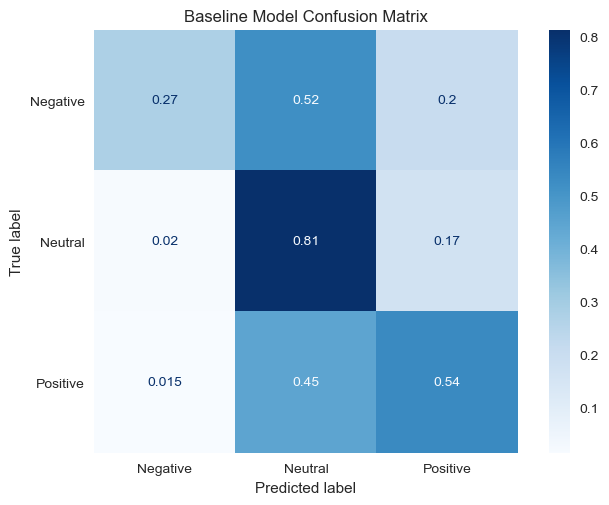

In [72]:
# Plot the confusion matrix for baseline model
from sklearn.metrics import plot_confusion_matrix
plt.style.use('seaborn')

fig, ax = plt.subplots()
plot_confusion_matrix(baseline_pipeline, raw_X_test, raw_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.grid(False)
plt.show()

### Preprocessed Data

In [73]:
# Run the logistic regression on processed data
baseline_pipeline.fit(X_train_processed, y_train)

processed_y_pred = baseline_pipeline.predict(X_test_processed)
accuracy_score(y_test, processed_y_pred)

0.6768402154398564

### TF-IDF Vectorizer

In [74]:
# Change the count vectorizer to TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english', lowercase=False, ngram_range=(1,2))

tfidf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
tfidf_pipeline.fit(X_train_processed, y_train)

tfidf_y_pred = tfidf_pipeline.predict(X_test_processed)
accuracy_score(y_test, tfidf_y_pred)

0.6885098743267505

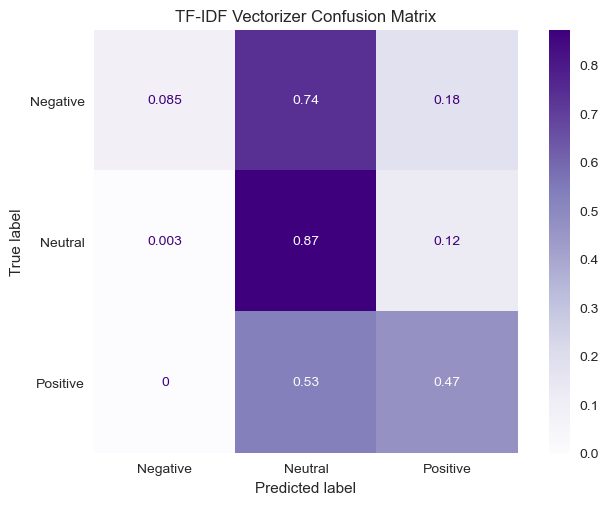

In [75]:
# Plot the confusion matrix for TF-IDF vectorizer
fig, ax = plt.subplots()
plot_confusion_matrix(tfidf_pipeline, X_test_processed, y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('TF-IDF Vectorizer Confusion Matrix')
plt.grid(False)
plt.show()

## Machine Learning Pipeline

In [83]:
# Load cleaned data and split intro train and test sets
clean_data = pd.read_csv('data/cleaned_tweets.csv')
clean_X = clean_data['text']
clean_y = clean_data['target']
clean_X_train, clean_X_test, clean_y_train, clean_y_test = train_test_split(clean_X, clean_y, random_state=112221, stratify=clean_y)

In [80]:
# Create a function to run models using pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def run_model(dict_model, type_, cmap):
    metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Accuracy', 'Type'])

    for name, model in dict_model.items():
        print(f'Running... {name} Model:')
        pipeline = Pipeline(steps=[('tfidf', tfidf), ('classifier', model['classifier'])])
        pipeline.fit(clean_X_train, clean_y_train) 

        y_pred = pipeline.predict(clean_X_test)

        cv_score = cross_val_score(pipeline, clean_X_train, clean_y_train, cv=3)
        cv_score_mean = round(np.mean(cv_score), 4)

        accuracy = accuracy_score(clean_y_test, y_pred)
            
        metric_table = metric_table.append({'Model': name, 'CV Score': cv_score_mean, 'Accuracy': round(accuracy, 4), 'Type': type_}, ignore_index=True)
        
        print(f'Cross Validation Score: {metric_table.iloc[-1,1]}')
        print(f'Test Accuracy Score: {metric_table.iloc[-1,2]}\n')
        
        fig, ax = plt.subplots()
        plot_confusion_matrix(pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap=cmap)
        plt.title(f'{name} Confusion Matrix')
        plt.grid(False)
        plt.show()
    
    return metric_table

## Classification Models <a class="anchor" id="Classification"></a>

In [77]:
# Import classification models from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier

In [78]:
# Create a dictionary of all models to run with default parameters
baseline_models = {'LogisticRegression': {'classifier': LogisticRegression(max_iter=1000, random_state=20211122)}, 
                   'MultinomialNB': {'classifier': MultinomialNB()},
                   'DecisionTree': {'classifier': DecisionTreeClassifier(random_state=20211122)},
                   'RandomForest': {'classifier': RandomForestClassifier(random_state=20211122)},
                   'ExtraTrees': {'classifier': ExtraTreesClassifier(random_state=20211122)},
                   'GradientBoost': {'classifier': GradientBoostingClassifier(random_state=20211122)},
                   'SGDClassifier': {'classifier': SGDClassifier(random_state=20211122)},
                  }

Running... LogisticRegression Model:
Cross Validation Score: 0.6751
Test Accuracy Score: 0.7022



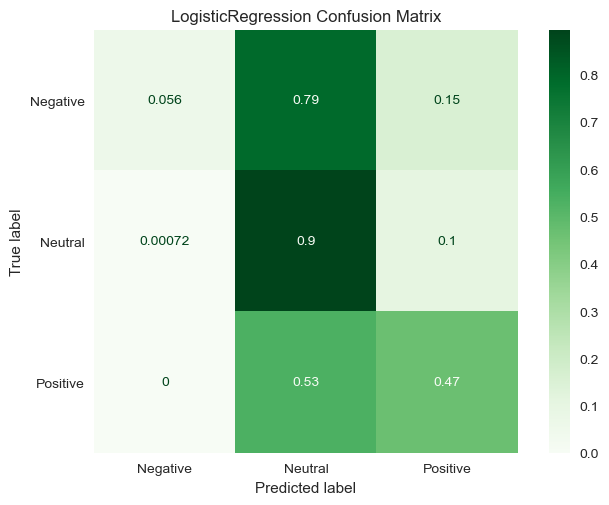

Running... MultinomialNB Model:
Cross Validation Score: 0.6451
Test Accuracy Score: 0.6615



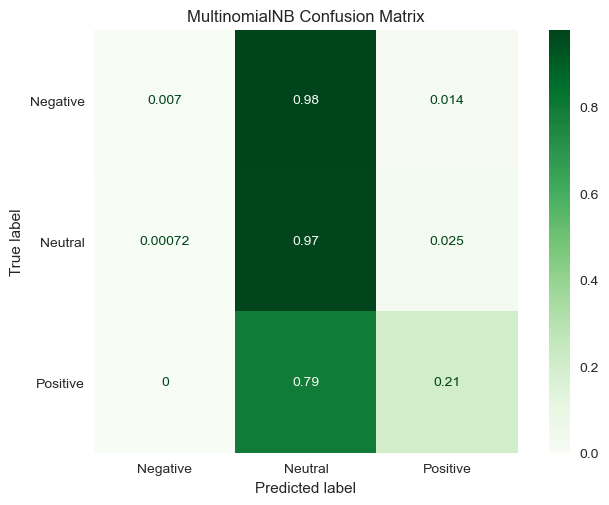

Running... DecisionTree Model:
Cross Validation Score: 0.5973
Test Accuracy Score: 0.6005



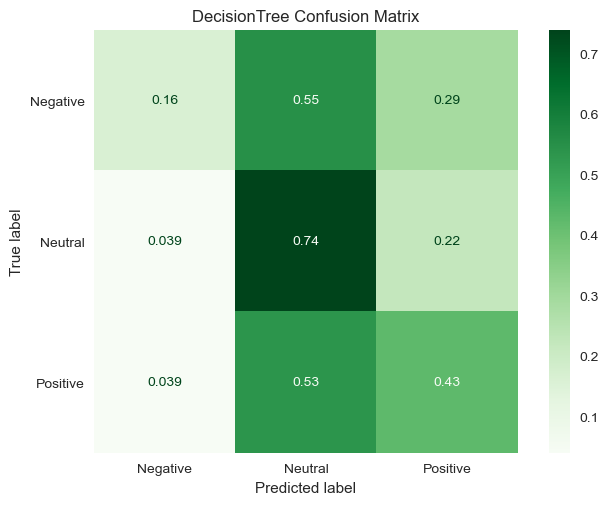

Running... RandomForest Model:
Cross Validation Score: 0.6666
Test Accuracy Score: 0.6792



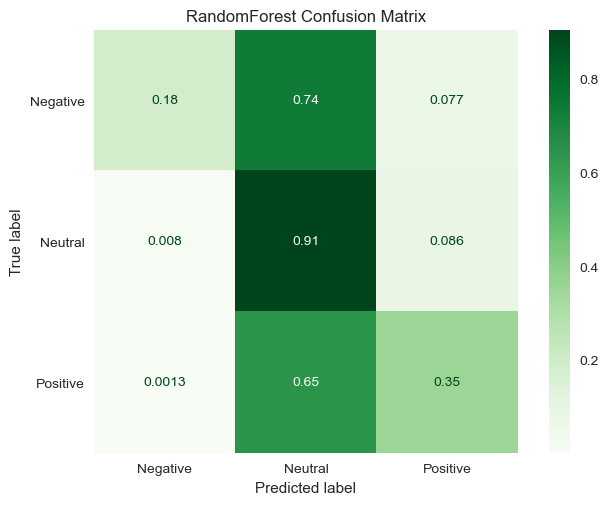

Running... ExtraTrees Model:
Cross Validation Score: 0.6661
Test Accuracy Score: 0.6814



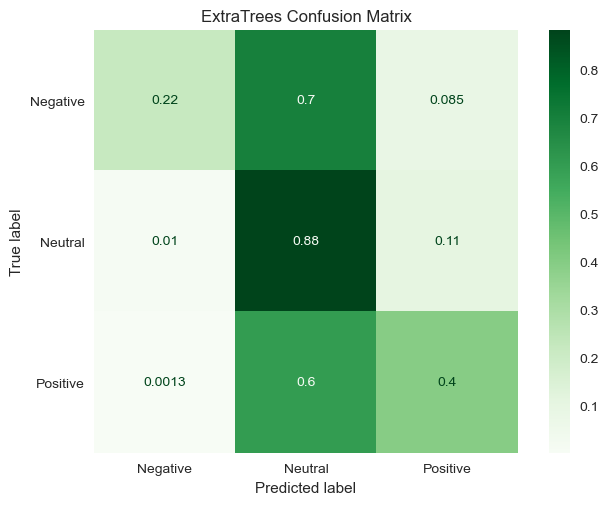

Running... GradientBoost Model:
Cross Validation Score: 0.6589
Test Accuracy Score: 0.6726



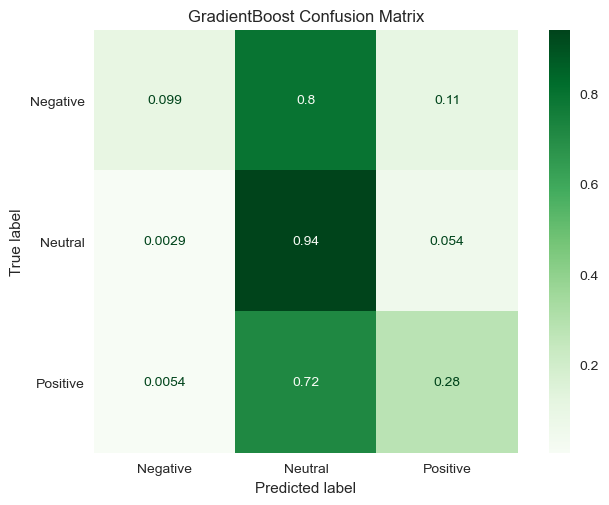

Running... SGDClassifier Model:
Cross Validation Score: 0.6732
Test Accuracy Score: 0.7141



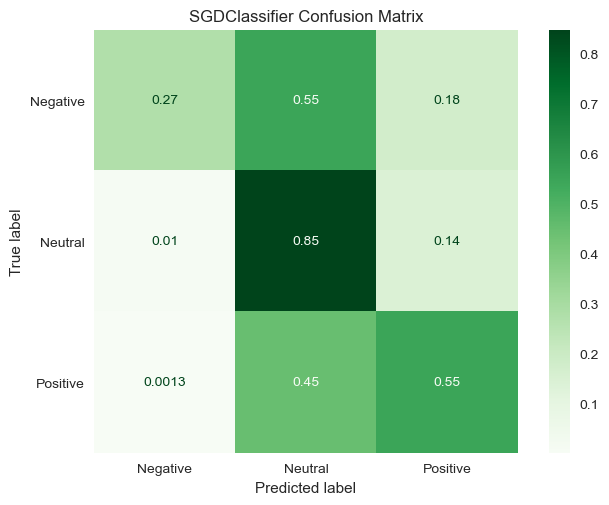

,Model,CV Score,Accuracy,Type
0,LogisticRegression,0.6751,0.7022,Baseline
1,MultinomialNB,0.6451,0.6615,Baseline
2,DecisionTree,0.5973,0.6005,Baseline
3,RandomForest,0.6666,0.6792,Baseline
4,ExtraTrees,0.6661,0.6814,Baseline
5,GradientBoost,0.6589,0.6726,Baseline
6,SGDClassifier,0.6732,0.7141,Baseline


In [81]:
# Use function created above to run the baseline models
baseline_table = run_model(baseline_models, 'Baseline', 'Blues')
baseline_table

## Fine-Tuning the Models
GridsearchCV is performed to find the optimal hyperparameters for the classification models. This was run on a separate notebook [here](https://github.com/czarinagluna/Twitter-Sentiment-Analysis/blob/main/GridSearchCV.ipynb).

In [89]:
# Create a dictionary of fine-tuned models to run with optimal parameters
finetuned_models = {'LogisticRegression': {'classifier': LogisticRegression(C=1, fit_intercept=True, solver='lbfgs', max_iter=1000, random_state=20211122)}, 
                   'MultinomialNB': {'classifier': MultinomialNB(alpha=0.2)},
                   'DecisionTree': {'classifier': DecisionTreeClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)},
                   'RandomForest': {'classifier': RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=112221)},
                   'ExtraTrees': {'classifier': ExtraTreesClassifier(min_samples_split=10, n_estimators=300, random_state=112222)},
                   'GradientBoost': {'classifier': GradientBoostingClassifier(max_depth=6, min_samples_leaf=3, min_samples_split=10, random_state=112221)},
                   'SGDClassifier': {'classifier': SGDClassifier(penalty='elasticnet', l1_ratio=0.15, max_iter=200, random_state=1127)},
                  }

Running... LogisticRegression Model:
Cross Validation Score: 0.6751
Test Accuracy Score: 0.7022



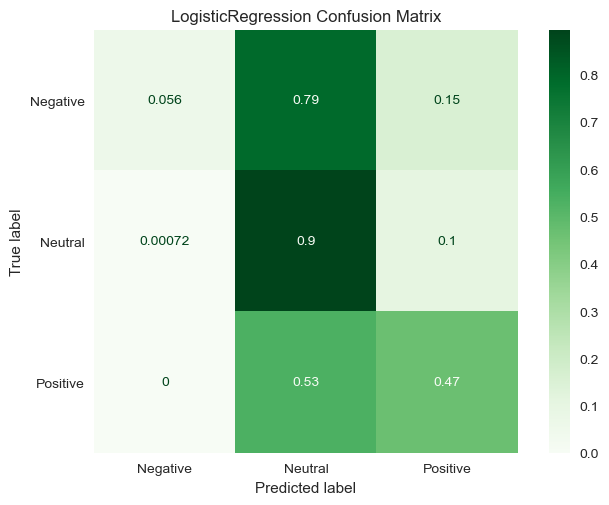

Running... MultinomialNB Model:
Cross Validation Score: 0.6685
Test Accuracy Score: 0.6942



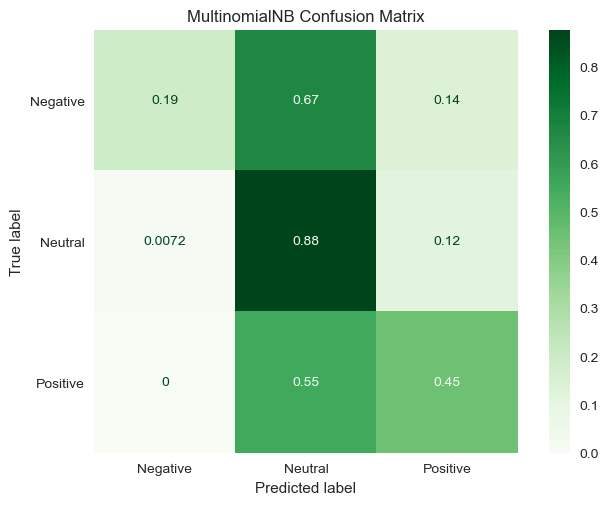

Running... DecisionTree Model:
Cross Validation Score: 0.6315
Test Accuracy Score: 0.6284



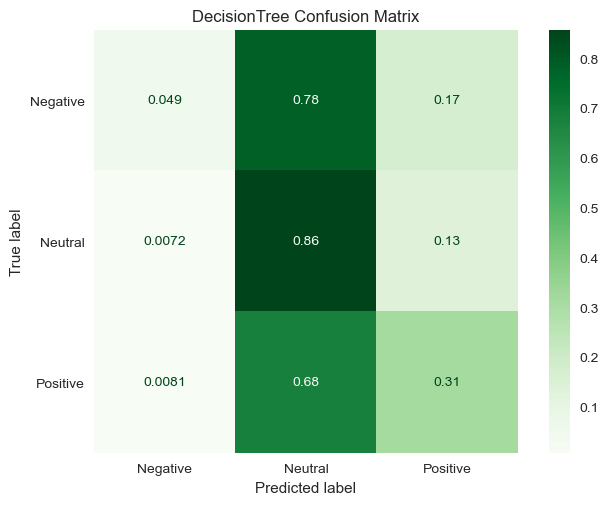

Running... RandomForest Model:
Cross Validation Score: 0.6651
Test Accuracy Score: 0.6818



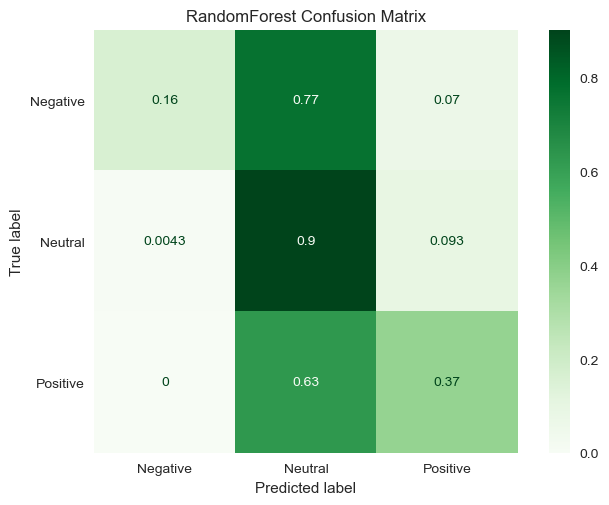

Running... ExtraTrees Model:
Cross Validation Score: 0.672
Test Accuracy Score: 0.6863



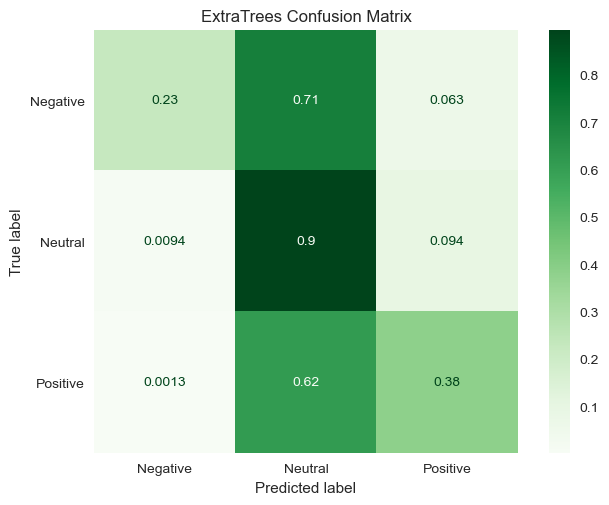

Running... GradientBoost Model:
Cross Validation Score: 0.6657
Test Accuracy Score: 0.6787



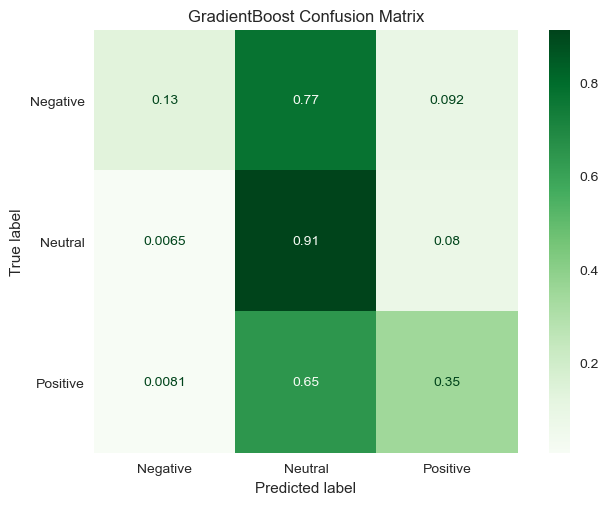

Running... SGDClassifier Model:
Cross Validation Score: 0.6751
Test Accuracy Score: 0.7119



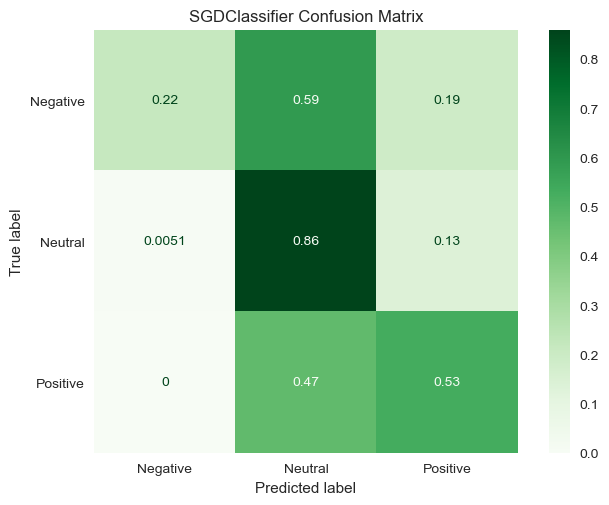

,Model,CV Score,Accuracy,Type
0,LogisticRegression,0.6751,0.7022,Fine-tuned
1,MultinomialNB,0.6685,0.6942,Fine-tuned
2,DecisionTree,0.6315,0.6284,Fine-tuned
3,RandomForest,0.6651,0.6818,Fine-tuned
4,ExtraTrees,0.6720,0.6863,Fine-tuned
5,GradientBoost,0.6657,0.6787,Fine-tuned
6,SGDClassifier,0.6751,0.7119,Fine-tuned


In [90]:
# Use function created above to run the fine-tuned models
finetuned_table = run_model(finetuned_models, 'Fine-tuned', 'Purples')
finetuned_table

## Neural network <a class="anchor" id="Neural_Network"></a>

In [98]:
from keras.utils import to_categorical

X = clean_X.copy()
y = to_categorical(clean_y.copy())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=clean_y)

In [99]:
X_train = preprocess(X_train).tolist()
X_test = preprocess(X_test).tolist()

In [101]:
from keras.preprocessing import text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(X_train)

In [103]:
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=100)

In [104]:
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

ros = RandomOverSampler(random_state=112221)
X_train_ros, y_train_ros = ros.fit_resample(X_train_pad, y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [108]:
from keras.layers import Dense, LSTM, Embedding
from keras.layers import Dropout, GlobalAveragePooling1D
from keras.models import Sequential

model = Sequential()
model.add(Embedding(X_train_ros.max()+1, 128))
model.add(LSTM(20, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         950144    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 20)          11920     
_________________________________________________________________
global_average_pooling1d (Gl (None, 20)                0         
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [111]:
history = model.fit(X_train_ros, y_train_ros, batch_size=64, epochs=25, validation_split=0.2)

Epoch 1/25
156/156 [==============================] - 11s 72ms/step - loss: 0.6055 - accuracy: 0.7245 - val_loss: 1.0992 - val_accuracy: 0.0000e+00
Epoch 2/25
156/156 [==============================] - 12s 77ms/step - loss: 0.5602 - accuracy: 0.7391 - val_loss: 1.0860 - val_accuracy: 0.0000e+00
Epoch 3/25
156/156 [==============================] - 12s 78ms/step - loss: 0.5315 - accuracy: 0.7412 - val_loss: 1.0648 - val_accuracy: 0.0000e+00
Epoch 4/25
156/156 [==============================] - 12s 75ms/step - loss: 0.5008 - accuracy: 0.7599 - val_loss: 0.9174 - val_accuracy: 0.1868
Epoch 5/25
156/156 [==============================] - 11s 73ms/step - loss: 0.4402 - accuracy: 0.8127 - val_loss: 0.6859 - val_accuracy: 0.6329
Epoch 6/25
156/156 [==============================] - 12s 75ms/step - loss: 0.3874 - accuracy: 0.8487 - val_loss: 0.5965 - val_accuracy: 0.7053
Epoch 7/25
156/156 [==============================] - 12s 77ms/step - loss: 0.3517 - accuracy: 0.8720 - val_loss: 0.6456 - v

In [115]:
y_pred = model.predict(X_test_pad)

y_test_arg = y_test.argmax(axis=1)
y_pred_arg = y_pred.argmax(axis=1)

neural_network_1 = accuracy_score(y_test_arg, y_pred_arg)

0.6473707467962881

In [119]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_arg, y_pred_arg, normalize='true')

array([[0.31690141, 0.51408451, 0.16901408],
       [0.04347826, 0.80434783, 0.15217391],
       [0.03778677, 0.54385965, 0.41835358]])

In [120]:
model = Sequential()
model.add(Embedding(X_train_ros.max()+1, 64))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          475072    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          12416     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [125]:
model.fit(X_train_ros, y_train_ros, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
156/156 [==============================] - 12s 76ms/step - loss: 0.1458 - accuracy: 0.9441 - val_loss: 0.1572 - val_accuracy: 0.9476
Epoch 2/100
156/156 [==============================] - 11s 73ms/step - loss: 0.1491 - accuracy: 0.9400 - val_loss: 0.1666 - val_accuracy: 0.9360
Epoch 3/100
156/156 [==============================] - 11s 71ms/step - loss: 0.1437 - accuracy: 0.9440 - val_loss: 0.1577 - val_accuracy: 0.9440
Epoch 4/100
156/156 [==============================] - 12s 79ms/step - loss: 0.1499 - accuracy: 0.9398 - val_loss: 0.1580 - val_accuracy: 0.9452
Epoch 5/100
156/156 [==============================] - 13s 85ms/step - loss: 0.1425 - accuracy: 0.9426 - val_loss: 0.1415 - val_accuracy: 0.9505
Epoch 6/100
156/156 [==============================] - 10s 65ms/step - loss: 0.1370 - accuracy: 0.9439 - val_loss: 0.1510 - val_accuracy: 0.9436
Epoch 7/100
156/156 [==============================] - 10s 63ms/step - loss: 0.1329 - accuracy: 0.9471 - val_loss: 0.1337 - val_ac

156/156 [==============================] - 12s 74ms/step - loss: 0.1008 - accuracy: 0.9566 - val_loss: 0.1159 - val_accuracy: 0.9493
Epoch 58/100
156/156 [==============================] - 12s 78ms/step - loss: 0.1021 - accuracy: 0.9567 - val_loss: 0.1135 - val_accuracy: 0.9549
Epoch 59/100
156/156 [==============================] - 12s 75ms/step - loss: 0.1047 - accuracy: 0.9547 - val_loss: 0.1214 - val_accuracy: 0.9501
Epoch 60/100
156/156 [==============================] - 12s 75ms/step - loss: 0.1151 - accuracy: 0.9512 - val_loss: 0.1287 - val_accuracy: 0.9440
Epoch 61/100
156/156 [==============================] - 12s 80ms/step - loss: 0.1027 - accuracy: 0.9556 - val_loss: 0.1113 - val_accuracy: 0.9533
Epoch 62/100
156/156 [==============================] - 12s 76ms/step - loss: 0.0999 - accuracy: 0.9559 - val_loss: 0.1132 - val_accuracy: 0.9509
Epoch 63/100
156/156 [==============================] - 13s 81ms/step - loss: 0.0976 - accuracy: 0.9578 - val_loss: 0.1119 - val_accuracy

In [126]:
y_pred = model.predict(X_test_pad)

y_test_arg = y_test.argmax(axis=1)
y_pred_arg = y_pred.argmax(axis=1)

neural_network_2 = accuracy_score(y_test_arg, y_pred_arg)

0.6416261599646487

In [127]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_arg, y_pred_arg, normalize='true')

array([[0.33802817, 0.46478873, 0.1971831 ],
       [0.04202899, 0.75144928, 0.20652174],
       [0.02699055, 0.47773279, 0.49527665]])

The accuracy score using the neural network model at 64% is lower than those of the earlier classification models, which reached up to 71%. 

## Clustering <a class="anchor" id="Clustering"></a>
After running the above supervised machine learning algorithms, we also performed unsupervised modeling to dig deeper into the data. We have predicted the labels of the text according to the sentiments, but with this unsupervised model, we create clusters of words that have high similarities with each other, without knowing the labeled sentiment. Weaving through the whole corpus of these tweets, we discovered different themes that can be found in this [notebook](https://github.com/czarinagluna/Twitter-Sentiment-Analysis). 

## Latent Dirichlet Allocation  <a class="anchor" id="LDA"></a>
In addition to clustering, we used Latent Dirichlet Allocation or LDA to further improve text classification by doing topic modeling. This unsupervised machine learning model used the text as input and found topics as output. The clusters that were created and the results of the LDA are actually complimentary, with very similar themes. We explored Latent Dirichlet Allocation modeling that can be found in this [notebook](https://github.com/czarinagluna/Twitter-Sentiment-Analysis/blob/main/LDA.ipynb).

# III. Final Model <a class="anchor" id="Final_Model"></a>
Let's compare the accuracy scores of all the models and choose our final model.

In [130]:
# Join the baseline and fined-tuned tables together
metric_table = pd.concat([baseline_table, finetuned_table], ignore_index=True)
metric_table['Name'] = metric_table['Model'] + ' ' + metric_table['Type']
metric_table

,Model,CV Score,Accuracy,Type,Name
0,LogisticRegression,0.6751,0.7022,Baseline,LogisticRegression Baseline
1,MultinomialNB,0.6451,0.6615,Baseline,MultinomialNB Baseline
2,DecisionTree,0.5973,0.6005,Baseline,DecisionTree Baseline
3,RandomForest,0.6666,0.6792,Baseline,RandomForest Baseline
4,ExtraTrees,0.6661,0.6814,Baseline,ExtraTrees Baseline
5,GradientBoost,0.6589,0.6726,Baseline,GradientBoost Baseline
6,SGDClassifier,0.6732,0.7141,Baseline,SGDClassifier Baseline
7,LogisticRegression,0.6751,0.7022,Fine-tuned,LogisticRegression Fine-tuned
8,MultinomialNB,0.6685,0.6942,Fine-tuned,MultinomialNB Fine-tuned
9,DecisionTree,0.6315,0.6284,Fine-tuned,DecisionTree Fine-tuned


The highest accuracy score we reached is at 71% using the Stochastic Gradient Descent classifier, both tuned and not. The runner up models are only 1-3 points away, such as the Logistic Regression, Multinomial Naive Bayes, and Extra Trees classifier. To narrow down these models, it helps to look at the confusion matrices, too.

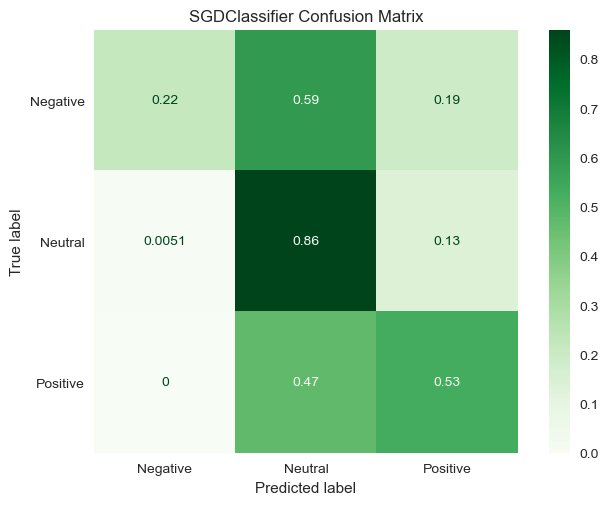

The confusion matrix for the SGD classifier printed earlier showed that this model misidentifies almost 20% of the negative sentiments as positive. Contrast this with the baseline Multinomial Naive Bayes that misidentifies 1% of the negative sentiments as positive, although the overall matrix of this model shows worse mislabeling of the other classes.

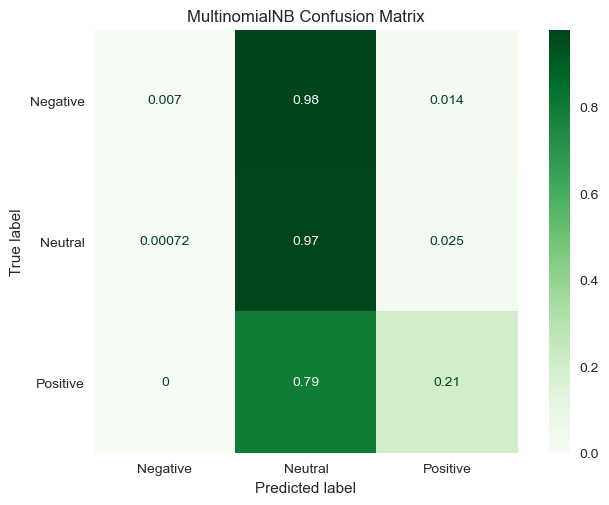

Comparing the confusion matrices and looking at the top right cell-false negatives identified as positive-lead us to choose the Extra trees model, that gives consideration to these factors: one of the highest accuracy scores, of almost 69%, and a lesser probability of mislabeling negatives as positive, at only 6%.

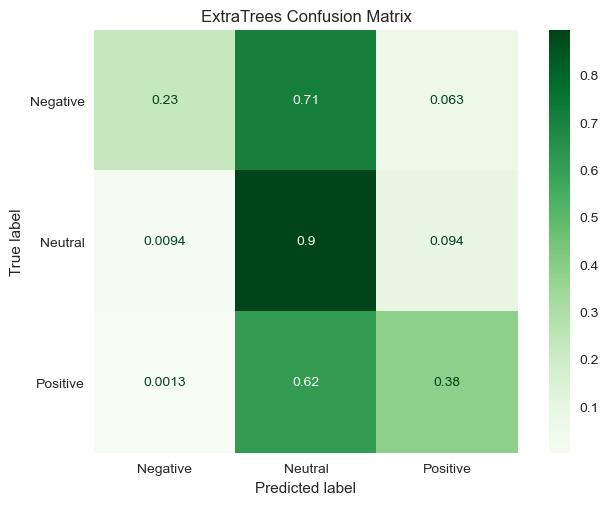

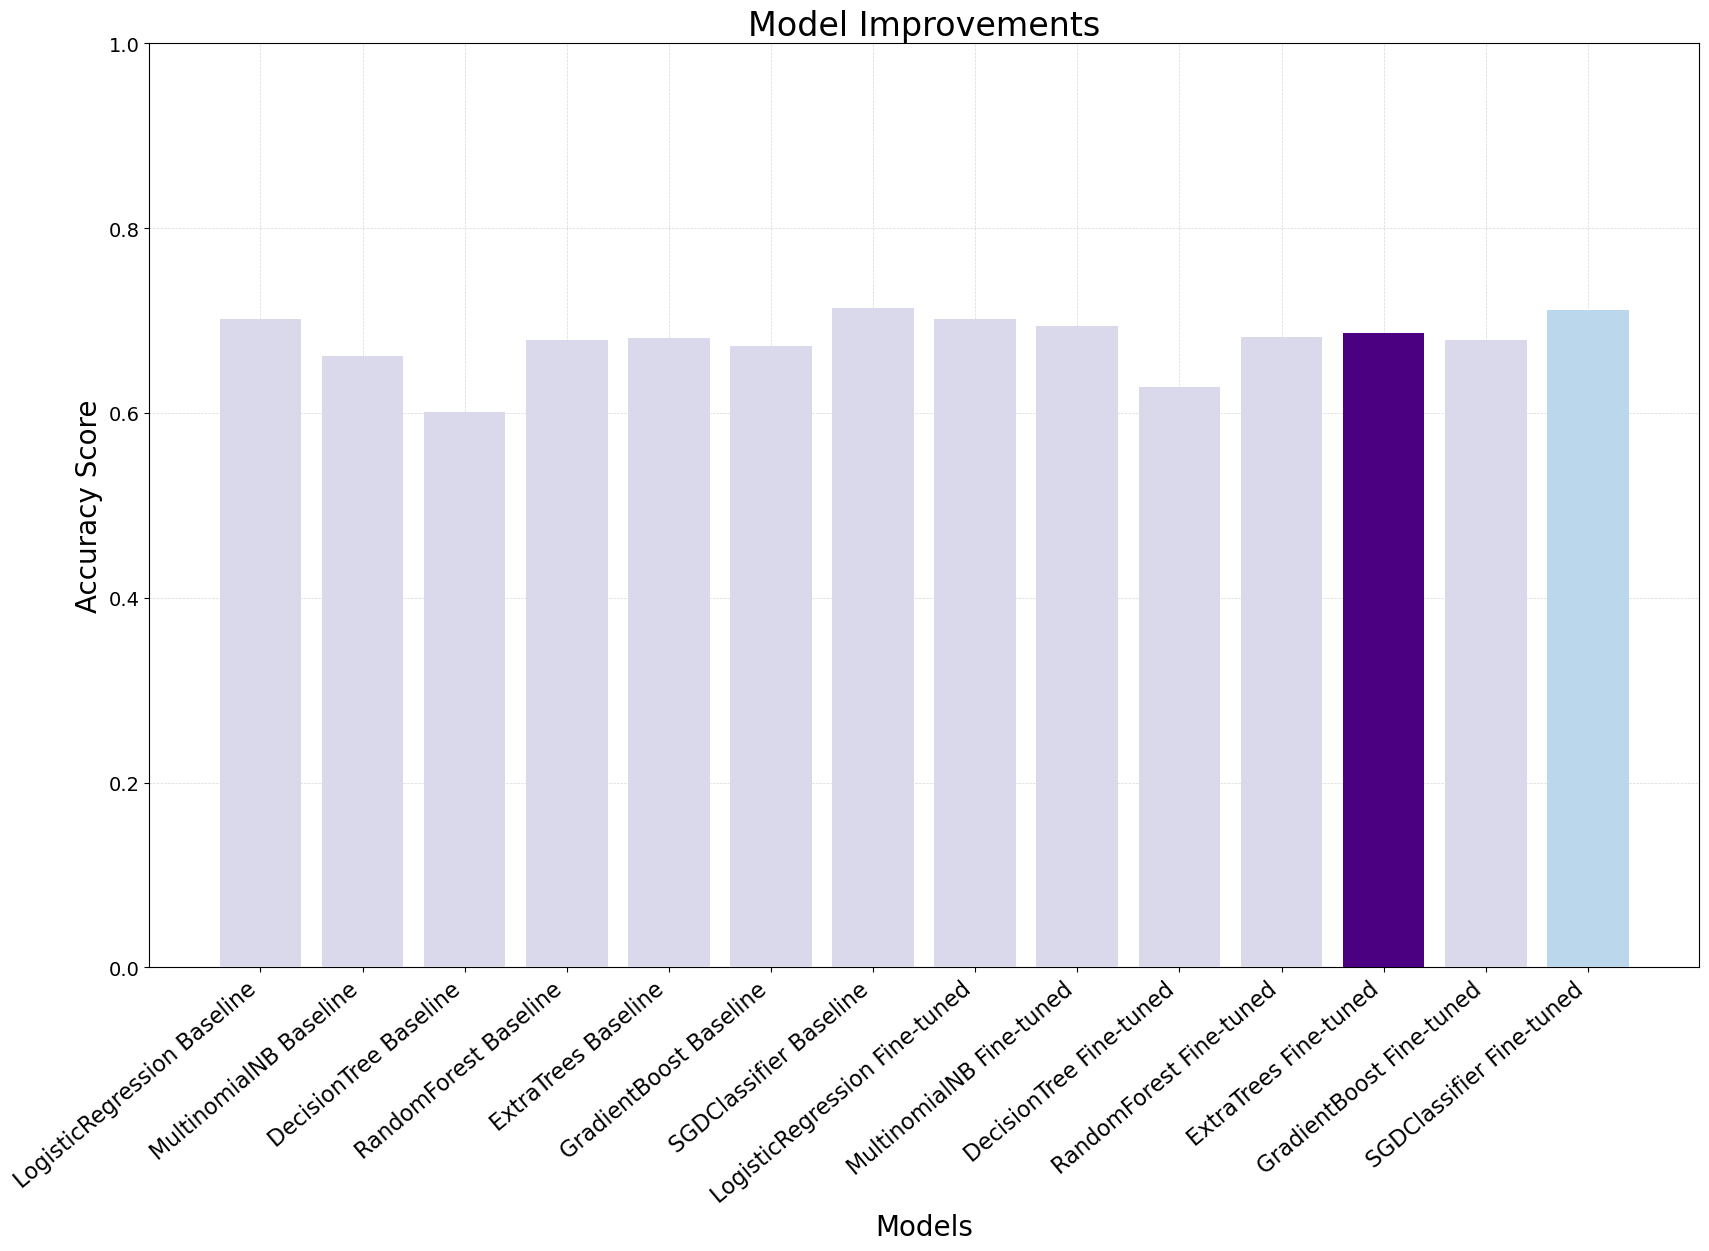

In [138]:
# Visualize the improvements among the baseline and fine-tuned models
plt.style.use('default')

fig, ax = plt.subplots(figsize=(20, 12))

c = ['#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', 
     '#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', '#d9d9eb', 
     '#d9d9eb', '#d9d9eb', 'indigo', '#d9d9eb', '#bad7ec',]

plt.bar(metric_table['Name'], metric_table['Accuracy'], color=c, zorder=3)

ax.set_title('Model Improvements', fontsize=24)
ax.set_xlabel('Models', fontsize=20)
plt.xticks(rotation=40, ha='right', fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0, 1)
ax.set_ylabel('Accuracy Score', fontsize=20)

plt.grid(linestyle = '--', linewidth = 0.5, alpha=.5, zorder=0)
plt.show()

# IV. Results <a class="anchor" id="Results"></a>
Now, let's run the final model on our test set to see the results.

In [149]:
# Use the Extra Trees model to predict
final_model = finetuned_models['ExtraTrees']['classifier']

final_pipeline = Pipeline(steps=[('tfifg', tfidf), ('final', final_model)])
final_pipeline.fit(clean_X_train, clean_y_train)

final_y_pred = final_pipeline.predict(clean_X_test)
accuracy_score(clean_y_test, final_y_pred)

0.6862571807335396

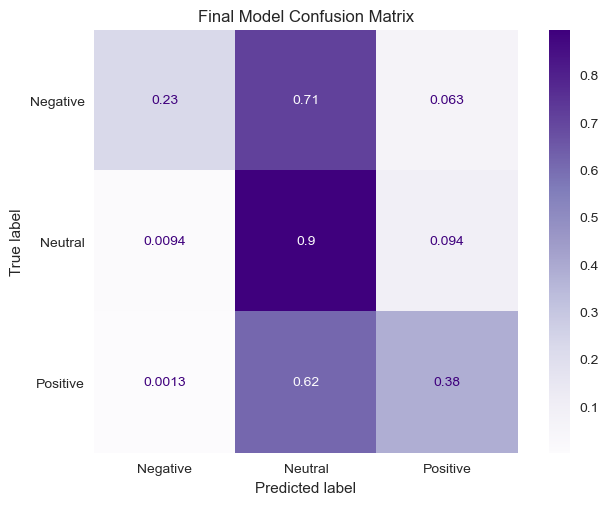

In [153]:
# Plot the confusion matrix for Extra Trees model
plt.style.use('seaborn')

fig, ax = plt.subplots()
plot_confusion_matrix(final_pipeline, clean_X_test, clean_y_test, display_labels=['Negative', 'Neutral', 'Positive'], ax=ax, normalize='true', cmap='Purples')
plt.title('Final Model Confusion Matrix')
plt.grid(False)
plt.show()

The final model has a test accuracy of close to 70%. As you can see in the matrix above, this model misidentifies only 6% of the negative sentiments as positive.

# V. Recommendations <a class="anchor" id="Recommendations"></a>
Given our sentiment results, we have the following recommendations for South by Southwest:

* Give brands feedback on their negative sentiments
  - When a brand has information on what are the products and features people have negative sentiment towards, they can make more targeted research and propose changes to those products. This would give the company a first layer of feedback so they can follow with more research.
* Retweet positive tweets
  - The more people positive comments can reach, the better. A team of people retweeting relevant tweets could significantly increase their reach. We'd also suggest prioritizing accounts that have a large amount of followers and are more active online than not.
* Investigate negative tweets
  - Are these directed at a specific product? A Brand? A flaw in the organization of the festival? Finding the answers to those questions should open venues for improvement.

## Next Steps <a class="anchor" id="Next_Steps"></a>

Following the delivery of our model, the next steps are to:
* Conduct sentiment analysis prior and after an event
  - Gauging sentiment towards a brand or product before and after an event can give the company an estimation on how positive or negative that event was for that brand or product, allowing them to make changes to future events based on these findings.
* Correlate sentiment analysis with product sales
  - Companies can see if sentiment towards a certain product have a correlation with said product sales. If it does, that could give them another tool to predict future sales based on sentiment.

# Contact Us <a class="anchor" id="Contact"></a>

For any questions or recommendations, feel free to reach out to our team:

Czarina Luna: [LinkedIn](https://www.linkedin.com/in/czarinaluna/) | Email: czarinagarcialuna@gmail.com<br />
Marcelo Scatena: [LinkedIn](https://uk.linkedin.com/in/marcelo-scatena) | Email: marcelo.oddo@gmail.com<br />
Ross McKim: [LinkedIn](https://www.linkedin.com/in/ross-mckim) | Email: rmckim@gmail.com<br />
Piotr Czolpik: [LinkedIn](https://www.linkedin.com/in/piotr-czolpik-803119111) | Email: Piotrczo1992@gmail.com<br />